In [282]:
#from lib2to3.pytree import convert
import scipy.io
import numpy as np
import tensorflow as tf
import pandas as pd 
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras import Sequential, models, Model
from tensorflow.keras.utils import plot_model, array_to_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tinymlgen import port
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import pandas as pd
import pybboxes as pbx
from collections import defaultdict
from tqdm import tqdm
import shutil
import cv2
import matplotlib.pyplot as plt
import math
from PIL import Image

In [283]:
#as the labels are text, we have used label_encoder function to translate them into numbers
#classes is a dictionary, key is the number and value is the name of the road sign
x = np.load('C:\\Users\\poori\\x_low_gray.npy')
y = np.load('C:\\Users\\poori\\y_low_gray.npy')
print(np.shape(x))
print(np.shape(y))
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)
decoded_y = label_encoder.inverse_transform(encoded_y)
classes = dict(zip(encoded_y, decoded_y)) # a dict is defined
label_encoder.classes_ = classes
print('Classifications in Dict format:',classes)
print('Number of classifications:',len(classes))
classes_txt = np.array([np.array(v) for v in classes.values()])
print('Classifications in text format:',classes_txt)


(1916, 28, 28)
(1916,)
Classifications in Dict format: {17: 'PRIORITY_ROAD', 13: 'PASS_EITHER_SIDE', 15: 'PASS_RIGHT_SIDE', 9: 'GIVE_WAY', 6: '70_SIGN', 8: '90_SIGN', 12: 'OTHER', 7: '80_SIGN', 4: '50_SIGN', 16: 'PEDESTRIAN_CROSSING', 5: '60_SIGN', 3: '30_SIGN', 10: 'NO_PARKING', 14: 'PASS_LEFT_SIDE', 1: '110_SIGN', 18: 'STOP', 0: '100_SIGN', 11: 'NO_STOPPING_NO_STANDING', 2: '120_SIGN', 19: 'URDBL'}
Number of classifications: 20
Classifications in text format: ['PRIORITY_ROAD' 'PASS_EITHER_SIDE' 'PASS_RIGHT_SIDE' 'GIVE_WAY' '70_SIGN'
 '90_SIGN' 'OTHER' '80_SIGN' '50_SIGN' 'PEDESTRIAN_CROSSING' '60_SIGN'
 '30_SIGN' 'NO_PARKING' 'PASS_LEFT_SIDE' '110_SIGN' 'STOP' '100_SIGN'
 'NO_STOPPING_NO_STANDING' '120_SIGN' 'URDBL']


In [284]:
x_train, x_test, y_train, y_test = train_test_split(x, encoded_y, test_size=0.2, random_state=4)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=4)
#print("size of x_train is ", np.shape(x_train))
#print("size of x_test is ", np.shape(x_test))
#print("size of x_val is ", np.shape(x_val))


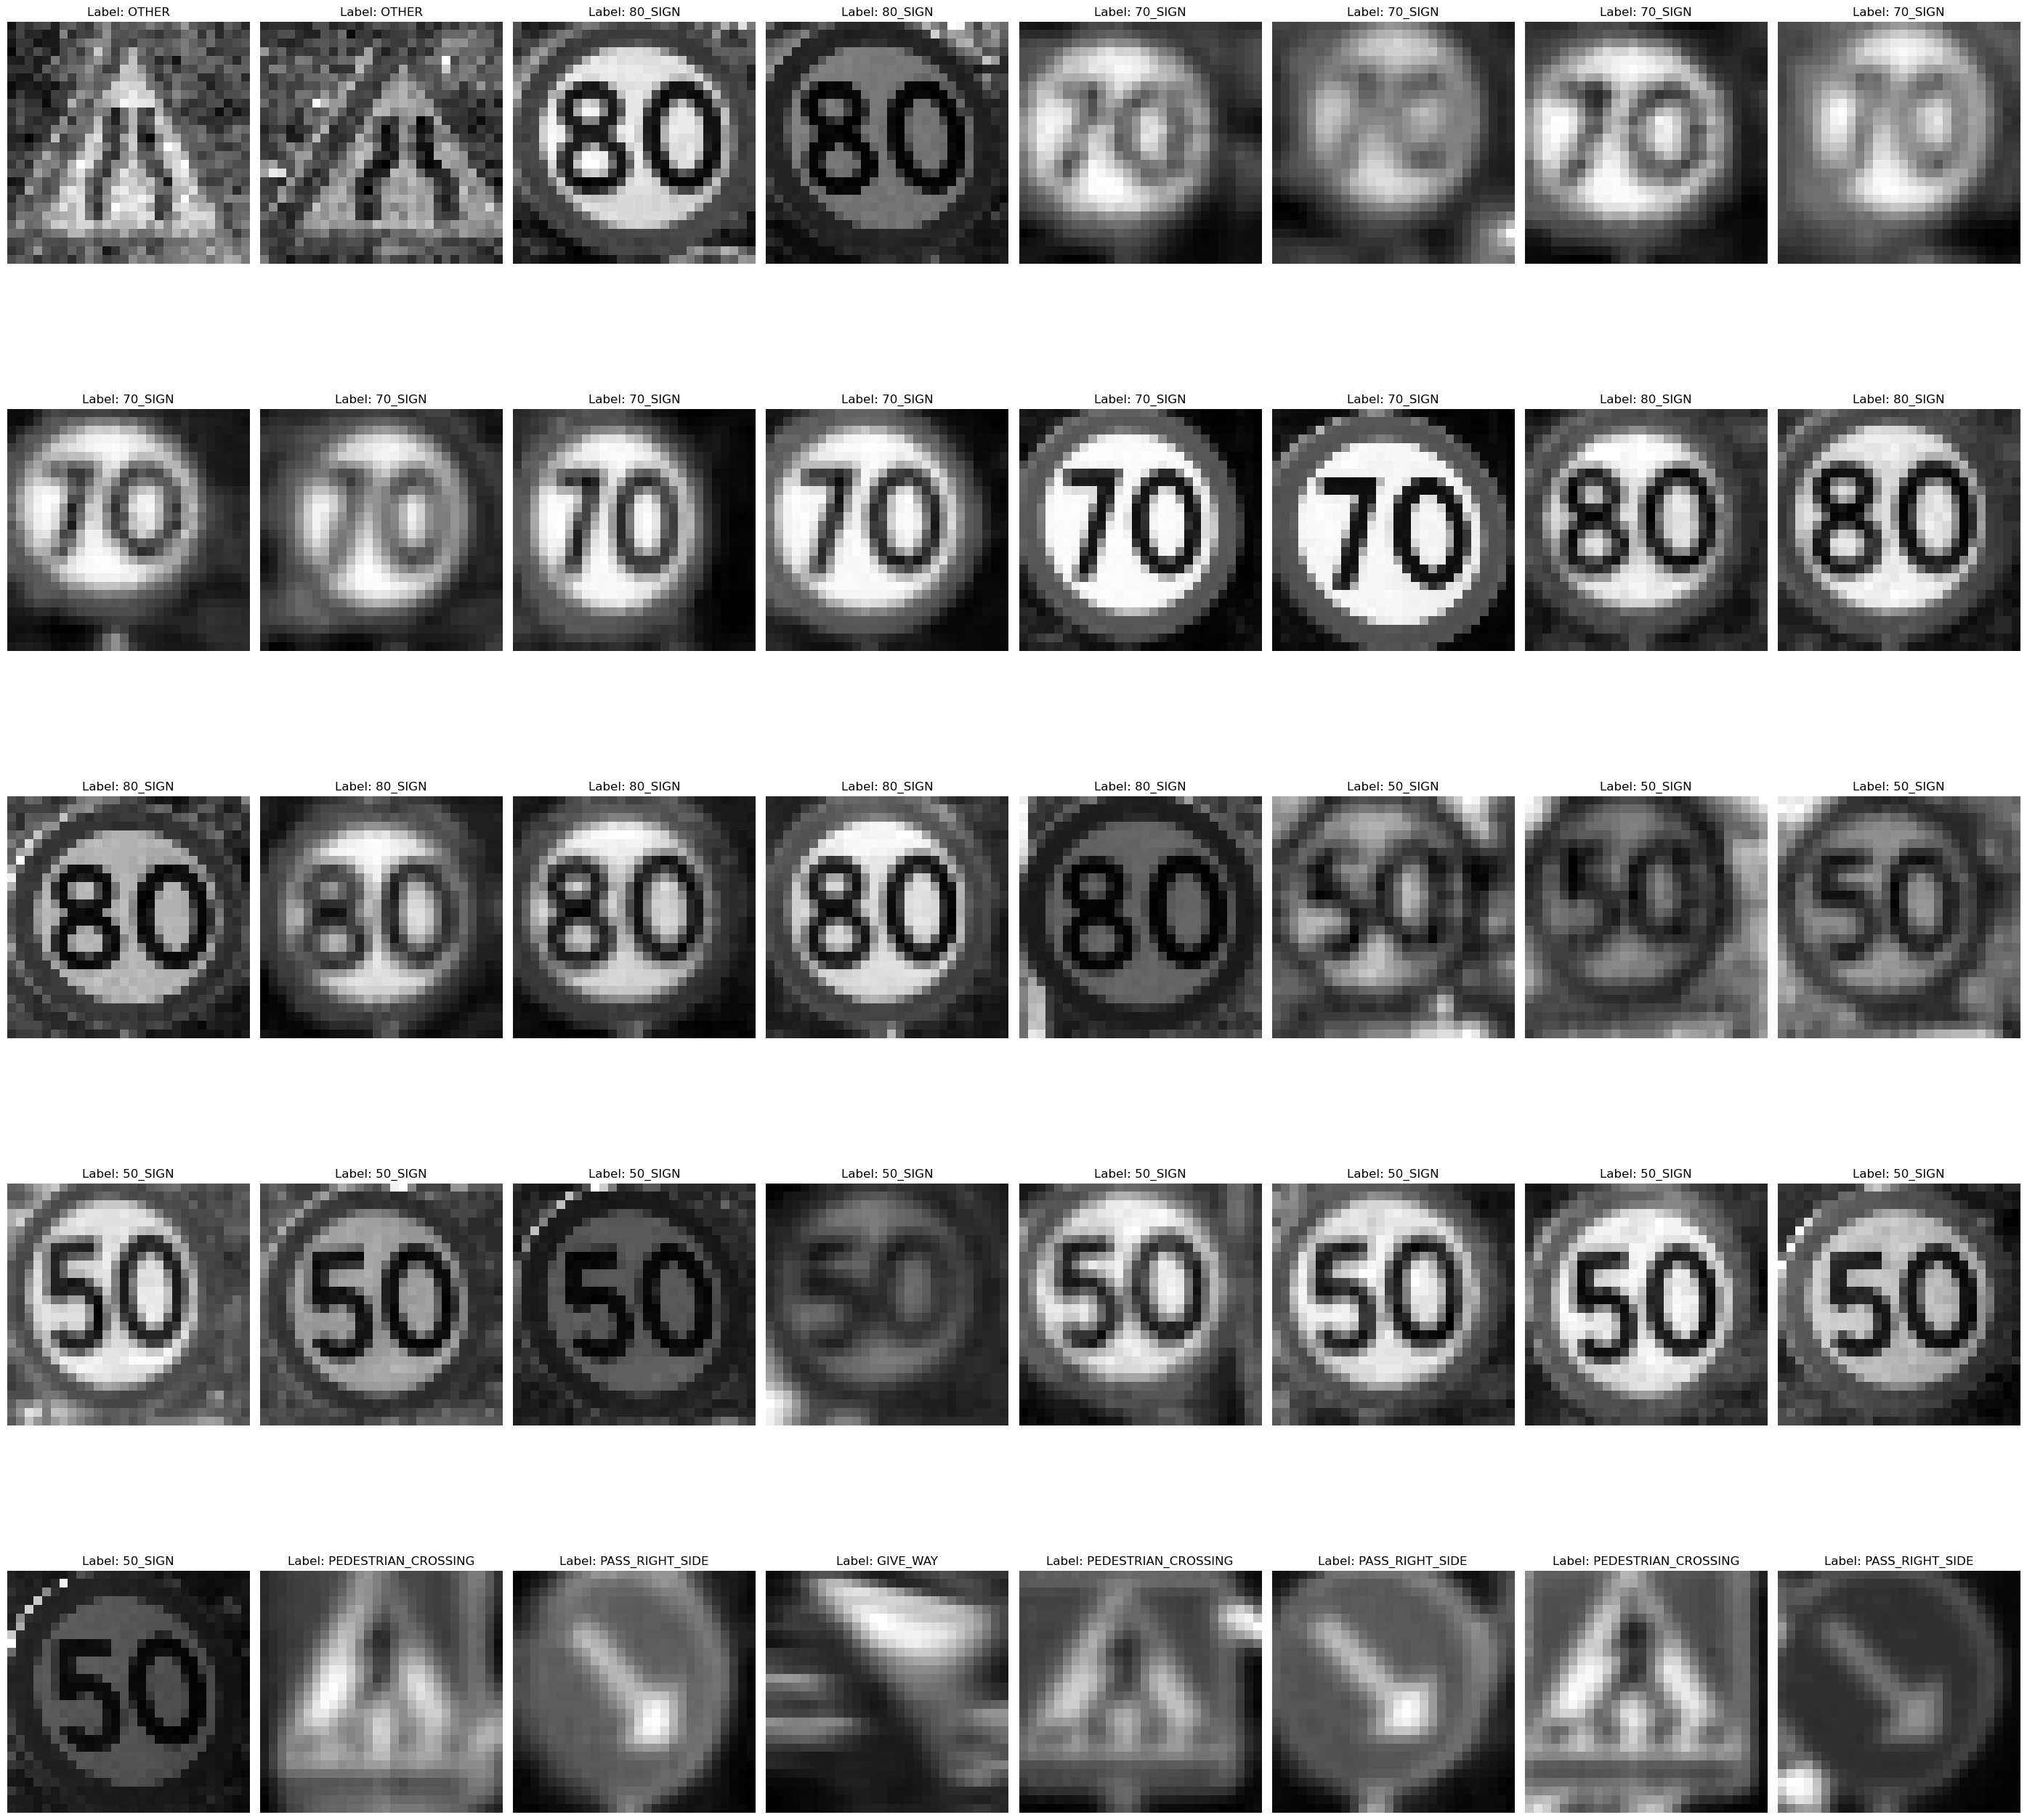

In [285]:

# Display images in subplots
num_rows = 5
num_cols = 8
total_images = num_rows * num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(28, 28))

for i in range(total_images):
    if i < len(x):
        image = x[i+50]
        label = y[i+50]
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(image, cmap='gray') 
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    else:
        axes[i // num_cols, i % num_cols].axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()


In [286]:
# dataset reshape
x_train = x_train.reshape((-1, x_train.shape[1], x_train.shape[2], 1))
print("Now, size of x_train is ", np.shape(x_train))

x_test = x_test.reshape((-1, x_test.shape[1], x_test.shape[2], 1))
print("Now, size of x_test is ", np.shape(x_test))

x_val = x_val.reshape((-1, x_val.shape[1], x_val.shape[2], 1))
print("Now, size of x_train is ", np.shape(x_val))




Now, size of x_train is  (1378, 28, 28, 1)
Now, size of x_test is  (384, 28, 28, 1)
Now, size of x_train is  (154, 28, 28, 1)


In [287]:
model_final = Sequential([
    
    Conv2D(8, (3,3), activation='relu', input_shape=x_train.shape[1:]),
    MaxPool2D((3, 3)),
    Conv2D(16, (2,2), activation='relu'),
    MaxPool2D((3, 3)),    
    #Conv2D(8, (2,2), activation='relu'),
    #MaxPool2D((2, 2)),
    
    Flatten(),

    Dense(75, activation='relu', name = 'dense_0'),
    Dropout(0.2),
    #Dynamic layers
    Dense(35, activation='relu', name = 'dense_1'),
    Dense(30, activation='relu', name = 'dense_2'),
    Dense(20, activation='softmax', name = 'dense_3') # probability
])

model.summary()
num_dynamic_layers = 3

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_135_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_135 (Conv2D)         (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_134 (MaxPool  (None, 8, 8, 8)           0         
 ing2D)                                                          
                                                                 
 conv2d_136 (Conv2D)         (None, 7, 7, 16)          528       
                                                                 
 max_pooling2d_135 (MaxPool  (None, 2, 2, 16)          0         
 ing2D)                                                          
                                                           

In [288]:
# define loss function and optimizer
model_final.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit the model
history = model_final.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=30, verbose=2)
loss, accuracy = model_final.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100}')

Epoch 1/50
46/46 - 4s - loss: 6.8324 - accuracy: 0.0740 - val_loss: 2.8661 - val_accuracy: 0.1104 - 4s/epoch - 88ms/step
Epoch 2/50
46/46 - 1s - loss: 2.9762 - accuracy: 0.1263 - val_loss: 2.7229 - val_accuracy: 0.1818 - 595ms/epoch - 13ms/step
Epoch 3/50
46/46 - 1s - loss: 2.7968 - accuracy: 0.1756 - val_loss: 2.6511 - val_accuracy: 0.2013 - 628ms/epoch - 14ms/step
Epoch 4/50
46/46 - 1s - loss: 2.6126 - accuracy: 0.2264 - val_loss: 2.4194 - val_accuracy: 0.2662 - 608ms/epoch - 13ms/step
Epoch 5/50
46/46 - 1s - loss: 2.4320 - accuracy: 0.2707 - val_loss: 2.3432 - val_accuracy: 0.2792 - 556ms/epoch - 12ms/step
Epoch 6/50
46/46 - 1s - loss: 2.2927 - accuracy: 0.3004 - val_loss: 2.0770 - val_accuracy: 0.3766 - 586ms/epoch - 13ms/step
Epoch 7/50
46/46 - 1s - loss: 2.0859 - accuracy: 0.3665 - val_loss: 2.0528 - val_accuracy: 0.4091 - 600ms/epoch - 13ms/step
Epoch 8/50
46/46 - 1s - loss: 2.0169 - accuracy: 0.3853 - val_loss: 1.9434 - val_accuracy: 0.3961 - 569ms/epoch - 12ms/step
Epoch 9/50


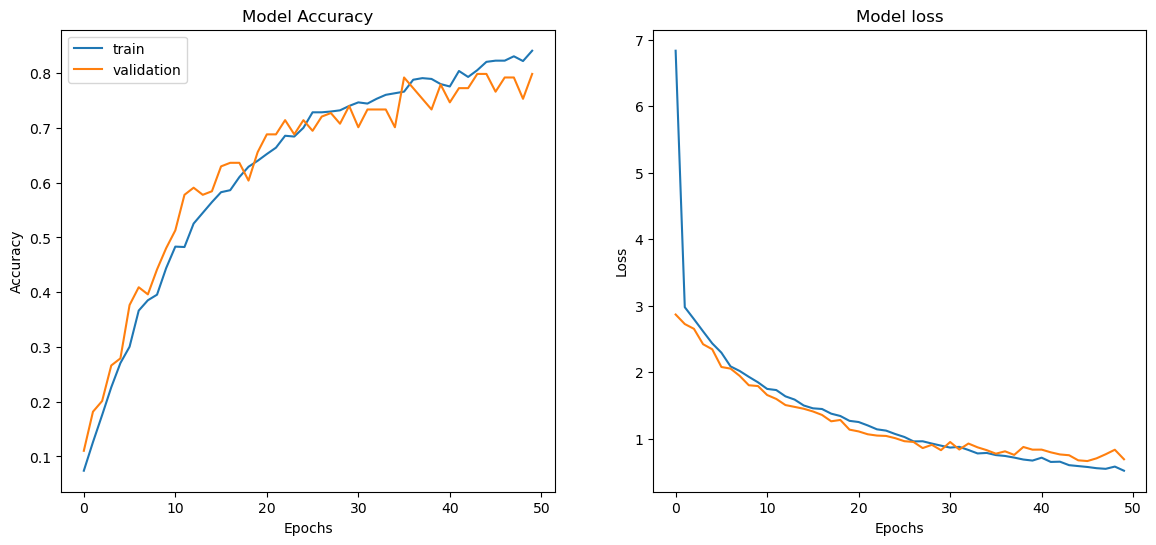

In [289]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="validation")

7
Predicted label: 80_SIGN


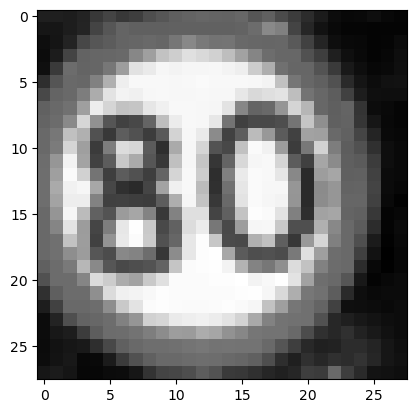

In [290]:
# input an image from x_val to test if the model works fine
image_index = 11
plt.imshow(np.squeeze(x_val[image_index]), cmap='gray')
# make a prediction
yhat = model_final.predict([np.expand_dims(x_val[image_index], axis=0)], verbose = 0)
result = np.argmax(yhat)
print(result)
value = classes.get(result)
print('Predicted label: {}'.format(value))

1/1 [==============================] - 0s 196ms/step
16
Predicted label: PEDESTRIAN_CROSSING


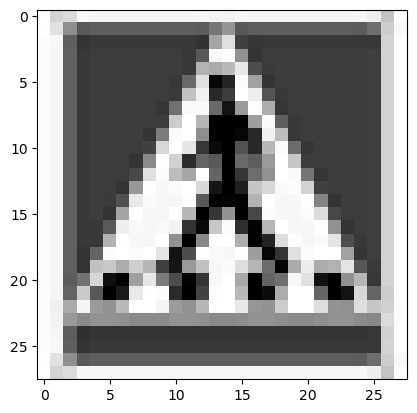

In [291]:
# to test the model with a random image from the internet
image = Image.open('C:\\Users\\poori\\OneDrive\\Desktop\\pd.jpg')
input_shape = (28, 28)
image = image.resize(input_shape)  # Resize the image to match the model's input size
grayscale_image = image.convert('L')
input_data = tf.keras.preprocessing.image.img_to_array(grayscale_image)
input_data = tf.expand_dims(input_data, axis=0)
#input_data = tf.keras.applications.mobilenet.preprocess_input(input_data)  # Preprocess according to your model

yhat = model_final.predict(input_data)
result = np.argmax(yhat)
print(result)
value = classes.get(result)
print('Predicted label: {}'.format(value))
plt.imshow(grayscale_image, cmap='gray')


In [292]:
# to save the model
model_final.save("model_final")

INFO:tensorflow:Assets written to: model_final\assets


INFO:tensorflow:Assets written to: model_final\assets


In [293]:
model = models.load_model('model_final')


x = model.layers[-(num_dynamic_layers + 1)].output 

model = Model(inputs = model.input, outputs = x)
model.summary()

# output contains input vector to DNN
cnn_pred_train = model.predict(x_train) 
cnn_pred_validation = model.predict(x_val) # need to transform validation to input vector for DNN
cnn_pred_test = model.predict(x_test) # perhaps merge with validation for Arduino

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_137_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_137 (Conv2D)         (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_136 (MaxPool  (None, 8, 8, 8)           0         
 ing2D)                                                          
                                                                 
 conv2d_138 (Conv2D)         (None, 7, 7, 16)          528       
                                                                 
 max_pooling2d_137 (MaxPool  (None, 2, 2, 16)          0         
 ing2D)                                                          
                                                          

In [294]:
# Save output from pretrained model (CNN) to .h, is also used below
first_layer_input_cnt = len(cnn_pred_train[0])

def append_photo_data(data, data_cnt, type, lines):
    lines.append("const float cnn_" + type + "_data[" + str(data_cnt) + "][" + str(first_layer_input_cnt) + "] = {")
    frames_str = []
    for frame in data:
        frame_values = [str(i) for i in frame]
        frames_str.append("  {" + ", ".join(frame_values) + "}")
    lines.append(",\n".join(frames_str))
    lines.append("};")
    lines.append("")

def append_label_data(data, data_cnt, type, lines):
    lines.append("const int " + type + "_labels[" + str(data_cnt) + "] = {")
    labels_str = [str(i) for i in data]
    lines.append("  " + ", ".join(labels_str))
    lines.append("};")
    lines.append("")

def append_class_data(data, data_cnt, lines):
    lines.append("const char* classes[" + str(data_cnt) + "] = {")
    classes_str = ['"' + str(i) + '"' for i in data]
    lines.append("  " + ", ".join(classes_str))
    lines.append("};")
    lines.append("")

PRINT, SAVE = 0, 1
PRINT_OR_SAVE = SAVE

def output_dataset(cnn_pred_train, y_train, file_suffix):
    train_data_cnt = len(y_train)
    validation_data_cnt = len(y_val)
    test_data_cnt = len(y_test)
    classes_cnt = classes

    if PRINT_OR_SAVE == PRINT:
        print("Label translations:", classes_txt)
        print("Number of inputs for first DNN layer:", first_layer_input_cnt)
        print("Sample size train data:", train_data_cnt)
        print("Sample size validation data:", validation_data_cnt)
        print("Sample size test data:", test_data_cnt)
        print("Number of classes:", classes_cnt)

        for i in range(train_data_cnt):
            print("Training Photo:", str(i), "has label:", str(y_train[i]))
            print(cnn_pred_train[i])

        for i in range(validation_data_cnt):
            print("Validation Photo:", str(i), "has label:", str(y_val[i]))
            print(x_val[i])

        for i in range(test_data_cnt):
            print("Test Photo:", str(i), "has label:", str(y_test[i]))
            print(x_test[i])

    elif PRINT_OR_SAVE == SAVE:
        lines = []
        lines.append("// Data file containing output from CNN as input to DNN")
        lines.append("// This file was automatically generated using 'tensorflow_main.ipynb'")
        lines.append("const int first_layer_input_cnt = " + str(first_layer_input_cnt) + ";")
        lines.append("const int train_data_cnt = " + str(train_data_cnt) + ";")
        lines.append("const int validation_data_cnt = " + str(validation_data_cnt) + ";")
        lines.append("const int test_data_cnt = " + str(test_data_cnt) + ";")
        lines.append("const int classes_cnt = " + str(classes_cnt) + ";")
        lines.append("")

        append_class_data(classes_txt, classes_cnt, lines)

        # Training labels
        append_label_data(y_train, train_data_cnt, "train", lines)

        # Validation labels
        append_label_data(y_val, validation_data_cnt, "validation", lines)

        # Test labels
        append_label_data(y_test, test_data_cnt, "test", lines)

        # Training data
        append_photo_data(cnn_pred_train, train_data_cnt, "train", lines)

        # Validation data
        append_photo_data(cnn_pred_validation, validation_data_cnt, "validation", lines)

        # Test data
        append_photo_data(cnn_pred_test, test_data_cnt, "test", lines)

        f = open("cnn_data" + file_suffix + ".h", "w")
        f.write("\n".join(lines))
        f.close()

# Total, unbiasad data-set
output_dataset(cnn_pred_train, y_train, "")


In [278]:
# Creating the DNN model, by extracting part from above
model_final_copy = models.clone_model(model_final)

in_layer = model_final_copy.layers[-(num_dynamic_layers + 1)].output
out_layer = model_final_copy.layers[-1].output 

dnn_model = Model(inputs = in_layer, outputs = out_layer)
dnn_model.summary()
dnn_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#dnn_pred_train = dnn_model.predict(cnn_pred_train)
#print(dnn_pred_train)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75)]              0         
                                                                 
 dense_1 (Dense)             (None, 35)                2660      
                                                                 
 dense_2 (Dense)             (None, 30)                1080      
                                                                 
 dense_3 (Dense)             (None, 20)                620       
                                                                 
Total params: 4360 (17.03 KB)
Trainable params: 4360 (17.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [279]:
# evaluate the untrained DNN model
def print_dnn_accuracy(input, labels, name, verbose=False):
    y_pred_class = dnn_model.predict(input)
    y_pred_class = np.argmax(np.array(y_pred_class), axis=1)

    y_diff = y_pred_class != labels
    print(name, "acc:", 1 - y_diff.sum() / len(y_diff))

    y_pred_txt = []
    y_true_txt = []

    for i in range(len(input)):
        y_pred_txt.append(classes_txt[y_pred_class[i]])
        y_true_txt.append(classes_txt[labels[i]])

    for i in range(len(y_diff)):
        if y_diff[i] and verbose:
            #plt.imshow(keras.utils.array_to_img(input[i]))
            print(" Is:", y_true_txt[i], "but was predicted as:", y_pred_txt[i])

print_dnn_accuracy(cnn_pred_train, y_train, "Train")
print_dnn_accuracy(cnn_pred_validation, y_val, "Validation")
print_dnn_accuracy(cnn_pred_test, y_test, "Test")

44/44 [==============================] - 0s 3ms/step
Train acc: 0.026850507982583482
5/5 [==============================] - 0s 3ms/step
Validation acc: 0.012987012987012991
12/12 [==============================] - 0s 3ms/step
Test acc: 0.02864583333333337


In [280]:
history_dnn = dnn_model.fit(cnn_pred_train, y_train, validation_data=(cnn_pred_validation, y_val), batch_size=5, epochs=10)

Epoch 1/10
276/276 [==============================] - 3s 5ms/step - loss: 1.8681 - accuracy: 0.5312 - val_loss: 1.2399 - val_accuracy: 0.6883
Epoch 2/10
276/276 [==============================] - 1s 4ms/step - loss: 0.8512 - accuracy: 0.7961 - val_loss: 1.0028 - val_accuracy: 0.7273
Epoch 3/10
276/276 [==============================] - 1s 4ms/step - loss: 0.6052 - accuracy: 0.8491 - val_loss: 0.9908 - val_accuracy: 0.7338
Epoch 4/10
276/276 [==============================] - 1s 4ms/step - loss: 0.4803 - accuracy: 0.8890 - val_loss: 0.9795 - val_accuracy: 0.7338
Epoch 5/10
276/276 [==============================] - 1s 4ms/step - loss: 0.3976 - accuracy: 0.8991 - val_loss: 0.9652 - val_accuracy: 0.7468
Epoch 6/10
276/276 [==============================] - 1s 4ms/step - loss: 0.3287 - accuracy: 0.9180 - val_loss: 0.9937 - val_accuracy: 0.7662
Epoch 7/10
276/276 [==============================] - 1s 4ms/step - loss: 0.2895 - accuracy: 0.9296 - val_loss: 0.9618 - val_accuracy: 0.7857
Epoch 

In [281]:
# Evaluation of the trained model
print_dnn_accuracy(cnn_pred_train, y_train, "Train", True)
print_dnn_accuracy(cnn_pred_validation, y_val, "Validation", True)
print_dnn_accuracy(cnn_pred_test, y_test, "Test", True)

44/44 [==============================] - 0s 3ms/step
Train acc: 0.9644412191582002
 Is: STOP but was predicted as: NO_STOPPING_NO_STANDING
 Is: 80_SIGN but was predicted as: 90_SIGN
 Is: PASS_EITHER_SIDE but was predicted as: 90_SIGN
 Is: 80_SIGN but was predicted as: 90_SIGN
 Is: 100_SIGN but was predicted as: 50_SIGN
 Is: 80_SIGN but was predicted as: 90_SIGN
 Is: OTHER but was predicted as: 100_SIGN
 Is: 80_SIGN but was predicted as: NO_PARKING
 Is: 30_SIGN but was predicted as: NO_STOPPING_NO_STANDING
 Is: OTHER but was predicted as: NO_STOPPING_NO_STANDING
 Is: 80_SIGN but was predicted as: OTHER
 Is: URDBL but was predicted as: 50_SIGN
 Is: 80_SIGN but was predicted as: 90_SIGN
 Is: 100_SIGN but was predicted as: NO_PARKING
 Is: 120_SIGN but was predicted as: NO_PARKING
 Is: STOP but was predicted as: NO_PARKING
 Is: 30_SIGN but was predicted as: 90_SIGN
 Is: STOP but was predicted as: 90_SIGN
 Is: OTHER but was predicted as: 50_SIGN
 Is: GIVE_WAY but was predicted as: 90_SIGN
 I

In [29]:
c_code = port(model, variable_name='road_sign_detection', pretty_print=True,optimize=False)
filename = 'road.h'
with open(filename,'w') as f: 
    f.write(c_code)

INFO:tensorflow:Assets written to: C:\Users\poori\AppData\Local\Temp\tmp2i449szc\assets


INFO:tensorflow:Assets written to: C:\Users\poori\AppData\Local\Temp\tmp2i449szc\assets


In [30]:
#Lite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open('./modellite.tflite','wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\poori\AppData\Local\Temp\tmpena_ps07\assets


INFO:tensorflow:Assets written to: C:\Users\poori\AppData\Local\Temp\tmpena_ps07\assets


184032